In [1]:
import numpy as np
from dLdp import analytic_dLdp
from matplotlib import pyplot as plt
from matplotlib import style
from functools import partial

In [2]:
def plot_trajectories(q_traj,p_trajs,n_p):
    style.use('fivethirtyeight')
    p_trajs=p_trajs.reshape(-1,n_p,2)
    plt.plot(q_traj[0,:],q_traj[1,:],'*',label="Target")
    for i in range(n_p):
        plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label="Mobile Sensor {}".format(i))
    plt.legend()
    plt.show()


In [4]:
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([0.,0.])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])


In [5]:
q_traj=q[...,np.newaxis]
p_trajs=ps[...,np.newaxis]

# Path Planning with constant step size. That is $||\alpha_i \nabla_{p_i}L||=constant$

In [5]:
def polar_projection(q,ps,r):    
    """ 
        Return the projection of a set of points ps onto a circle centered at q with radius r
    """
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    dists=np.linalg.norm(ps-q,axis=1)

    dists[dists==0]=1 # Handling the zero distances
    ps_proj=((ps-q).T/dists * r).T +q
    return ps_proj

def FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon):
    """
        f_dLdp: a function handle, f_dLdp(q,ps)=dLdp.
        q: Current location of the target.
        ps: Current locations of the mobile sensors.
        n_p: The number of sensors
        n_timesteps: The number of timesteps to plan ahead. The total time horizon T will be T=n_timesteps*dt.
        
        max_linear_speed: the linear speed limit to be set on the mobile sensors.
        dt: the time differences between two consecutive waypoints.
        
        The update step size will be a constant = max_linear_speed * dt
        
        epsilon: when the planned trajectories end, how far away should they be to the target.
    """

    step_size=max_linear_speed*dt
    p_trajs=[]
    
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    p_trajs.append(ps)
    for i in range(n_timesteps):
        # Calculate the gradient
        grad=f_dLdp(q,ps)
        grad=grad.reshape(-1,2)
        grad_sizes=np.linalg.norm(grad,axis=1)

        grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

        update_steps=(grad.T/grad_sizes * step_size).T # Calculate the update steps to be applied to ps

        candid_ps=ps+update_steps # Calculate the direct update before projecting onto the target sphere.

        # Project candid_ps onto the "surveillance circle" once it steps into it
        if not np.all(np.linalg.norm(candid_ps-q,axis=1)>=epsilon):
            insiders=np.linalg.norm(candid_ps-q,axis=1)<epsilon
            ps=candid_ps
            ps[insiders]=polar_projection(q,candid_ps,epsilon)[insiders] # Update ps.
            p_trajs.append(ps)
            break # Exit the loop
        else:
            ps=candid_ps # Update ps.
            p_trajs.append(ps)
    return np.array(p_trajs).reshape(-1,n_p,2) # Shape= (num_time_steps,num_sensors,2)

# A typical working example

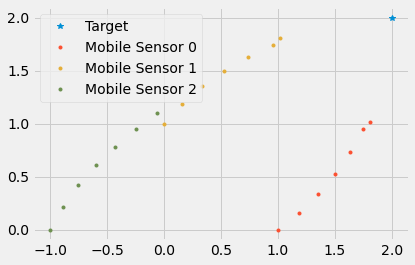

In [6]:
max_linear_speed=1.22
dt=0.2
epsilon=1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([2,2])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=100

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

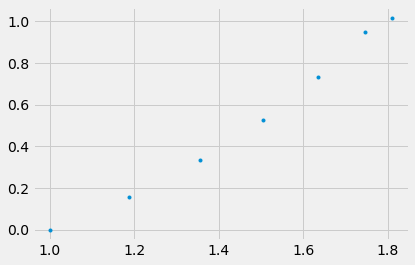

In [7]:
plt.plot(p_trajs[:,0,0],p_trajs[:,0,1],'.')

In [8]:
def unscaled_2D_spline_motion(waypoints,poly_order, state_space_dim):
    
    # Local Helper Functions
    def fit_spatial_polynomial(waypoints,poly_order, state_space_dim):
        """
            Fit a spatial polynomial p(s)-> R^state_space_dim, s in 0~1, to fit the waypoints.
        """
        if waypoints.shape[1]!=state_space_dim:
            waypoints=waypoints.T

        assert(waypoints.shape[1]==state_space_dim)

        n = waypoints.shape[0]

        s = np.array([i/(n-1) for i in range(n)])
        S = np.vstack([np.power(s,k) for k in range(poly_order+1)])
        S = S.T

        # The two formulas below are equivalent if S is full rank.
    #     poly_coefs= np.linalg.inv(S.dot(S.T))).dot(waypoints)
        poly_coefs = np.linalg.pinv(S).dot(waypoints)
        return poly_coefs,S

    # A debug-purpose function.
    # def polynomial(poly_coefs,x):
    #     '''
    #         Evaluate the value of the polynomial specified by poly_coefs at locations x.
    #     '''
    #     S = np.vstack([np.power(x,k) for k in range(len(poly_coefs))])
    #     y = np.array(poly_coefs).dot(S)
    #     return y

    def diff_poly_coefs(poly_coefs):
        '''
            Calculate the coefs of the polynomial after taking the first-order derivative.
        '''
        if len(poly_coefs)==1:
            coefs = [0]
        else:
            coefs = np.array(range(len(poly_coefs)))*poly_coefs
            coefs = coefs[1:]
        return coefs
    ######### End of Helper Functions #################################

    coef,S = fit_spatial_polynomial(waypoints,poly_order, state_space_dim)
    # coef.shape = (poly_order+1,state_space_dim)
    # S.shape = (n_waypoints,poly_order+1), 
    # S = [[1,s_i,s_i^2,s_i^3,...,s_i^poly_order]]_{i=0...n_waypoints}, s_i = i/n_waypoints
    
    dotCoef = np.vstack([diff_poly_coefs(coef[:,i]) for i in range(state_space_dim)]).T
    # dotCoef.shape = (poly_order,state_space_dim)
    
    ddotCoef = np.vstack([diff_poly_coefs(dotCoef[:,i]) for i in range(state_space_dim)]).T
    # ddotCoef.shape = (poly_order-1,state_space_dim)
    
    p = S[:,:poly_order+1].dot(coef)
    # p.shape = (n_waypoints,state_space_dim)
    
    pDot = S[:,:poly_order].dot(dotCoef)
    # pDot.shape = (n_waypoints,state_space_dim)
    
    pDDot = S[:,:poly_order-1].dot(ddotCoef)
    # pDot.shape = (n_waypoints,state_space_dim)
    
    theta = np.arctan2(pDot[:,1],pDot[:,0])
    # The facing angles at each p, shape=(n_waypoints,)
    
    v= np.linalg.norm(pDot,axis=1)
    # The velocity, derivative in s. shape = (n_waypoints,)
    
    omega = (pDDot[:,1]*pDot[:,0]-pDDot[:,0]*pDot[:,1])/np.power(v,2)
    # The angular velocity, rotating counter-clockwise as positive. shape=(n_waypoints,)
    return p,pDot,pDDot,theta,v,omega
def scaled_2D_spline_motion(waypoints,poly_order, state_space_dim):
    pass

In [29]:
waypoints = p_trajs[:,1,:]
poly_order=3
state_space_dim=2
p,pDot,pDDot,theta,v,omega=unscaled_2D_spline_motion(waypoints,poly_order, state_space_dim)

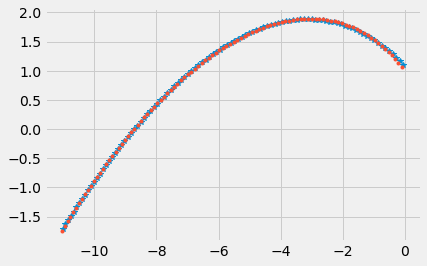

In [30]:
plt.plot(p[:,0],p[:,1],'*')
plt.plot(waypoints[:,0],waypoints[:,1],'.')


In [31]:
v/omega

array([ 6.72813847,  6.64954402,  6.57912367,  6.51670136,  6.46211045,
        6.41519352,  6.37580207,  6.3437963 ,  6.31904484,  6.3014244 ,
        6.29081952,  6.28712221,  6.29023158,  6.30005355,  6.31650041,
        6.33949051,  6.36894781,  6.40480152,  6.44698569,  6.4954388 ,
        6.55010334,  6.61092542,  6.67785433,  6.75084215,  6.82984332,
        6.91481424,  7.00571285,  7.10249826,  7.20513032,  7.31356926,
        7.42777528,  7.5477082 ,  7.67332708,  7.80458987,  7.94145304,
        8.08387128,  8.23179711,  8.38518062,  8.5439691 ,  8.70810679,
        8.87753452,  9.05218948,  9.23200491,  9.41690984,  9.6068288 ,
        9.80168161, 10.0013831 , 10.20584287, 10.41496507, 10.62864814,
       10.84678462, 11.06926092, 11.2959571 , 11.52674665, 11.76149632,
       12.00006589, 12.24230799, 12.48806787, 12.73718325, 12.98948412,
       13.24479254, 13.50292245, 13.7636795 , 14.02686087, 14.29225505,
       14.55964172, 14.82879152, 15.09946585, 15.37141678, 15.64

In [32]:
omega/np.pi * 180

array([111.26446551, 111.69457233, 112.04135143, 112.30324127,
       112.47906128, 112.56802541, 112.56975134, 112.48426491,
       112.31199994, 112.05379313, 111.71087446, 111.28485311,
       110.77769918, 110.19172179, 109.52954377, 108.7940736 ,
       107.98847509, 107.11613537, 106.18063183, 105.18569836,
       104.13519177, 103.03305858, 101.88330278, 100.68995502,
        99.45704342,  98.18856644,  96.88846794,  95.56061463,
        94.20877595,  92.83660659,  91.44763139,  90.04523285,
        88.63264093,  87.21292524,  85.78898924,  84.36356656,
        82.93921904,  81.51833644,  80.10313764,  78.69567303,
        77.29782814,  75.91132804,  74.53774268,  73.17849273,
        71.83485597,  70.50797408,  69.19885957,  67.90840301,
        66.63738021,  65.38645944,  64.15620861,  62.94710223,
        61.75952829,  60.59379486,  59.45013651,  58.32872042,
        57.22965222,  56.15298159,  55.09870749,  54.06678316,
        53.05712078,  52.06959587,  51.10405141,  50.16

In [33]:
v

array([13.06558244, 12.9628741 , 12.86541371, 12.77313427, 12.68596263,
       12.60381957, 12.52661992, 12.45427272, 12.38668134, 12.32374378,
       12.26535281, 12.21139632, 12.1617576 , 12.11631561, 12.07494538,
       12.03751835, 12.0039027 , 11.97396375, 11.94756438, 11.92456534,
       11.90482568, 11.88820314, 11.87455447, 11.86373583, 11.85560314,
       11.85001239, 11.84681997, 11.84588297, 11.84705948, 11.85020883,
       11.85519181, 11.86187095, 11.87011068, 11.87977751, 11.89074022,
       11.90286996, 11.9160404 , 11.93012785, 11.94501129, 11.9605725 ,
       11.97669608, 11.99326951, 12.01018317, 12.02733035, 12.04460728,
       12.06191309, 12.07914982, 12.09622239, 12.11303857, 12.12950895,
       12.1455469 , 12.16106849, 12.1759925 , 12.19024033, 12.20373591,
       12.21640572, 12.22817866, 12.23898603, 12.24876143, 12.25744073,
       12.26496198, 12.27126537, 12.27629314, 12.27998952, 12.2823007 ,
       12.28317471, 12.28256142, 12.28041244, 12.27668105, 12.27

In [34]:
theta/np.pi * 180

array([ 151.5164539 ,  152.64257904,  153.77262931,  154.90575482,
        156.04109181,  157.1777666 ,  158.31489956,  159.4516093 ,
        160.58701672,  161.72024918,  162.85044445,  163.97675467,
        165.09835009,  166.21442255,  167.32418888,  168.42689381,
        169.5218128 ,  170.60825442,  171.68556244,  172.75311758,
        173.81033892,  174.85668499,  175.8916545 ,  176.91478676,
        177.9256618 ,  178.92390022,  179.90916274, -179.11885044,
       -178.16040054, -177.21571128, -176.28497011, -175.36832956,
       -174.4659088 , -173.57779513, -172.70404571, -171.84468922,
       -170.99972759, -170.16913775, -169.35287336, -168.55086649,
       -167.76302937, -166.98925599, -166.22942369, -165.48339472,
       -164.75101772, -164.03212908, -163.32655436, -162.63410949,
       -161.95460199, -161.28783209, -160.63359381, -159.99167587,
       -159.36186267, -158.74393508, -158.13767126, -157.54284733,
       -156.95923802, -156.38661732, -155.82475894, -155.27343

In [16]:
pDDot.shape

(7, 2)

In [17]:
x= np.linspace(-3,3,100)

coef=[0,0,-3,0,3]
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))



NameError: name 'polynomial' is not defined

In [18]:
waypoints = p_trajs[:,1,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*')
plt.plot(waypoints[:,0],waypoints[:,1],'.')


NameError: name 'fit_spatial_polynomial' is not defined

# Allowing more time steps and smaller epsilon

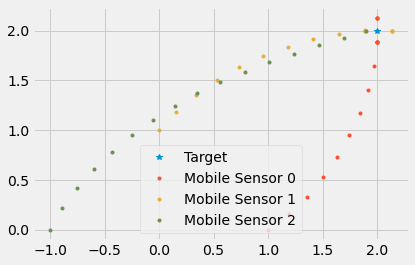

In [19]:
max_linear_speed=1.22
dt=0.2
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([2,2])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=50

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

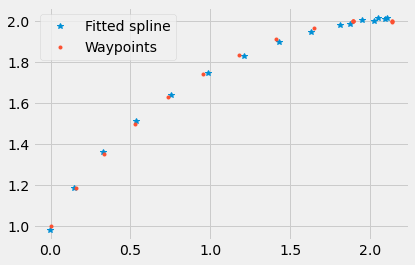

In [13]:
waypoints = p_trajs[:,1,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

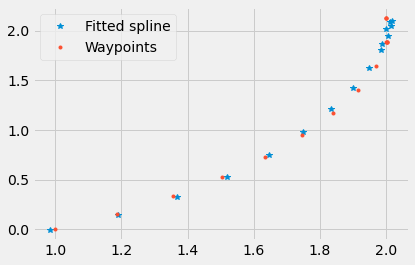

In [14]:
waypoints = p_trajs[:,0,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

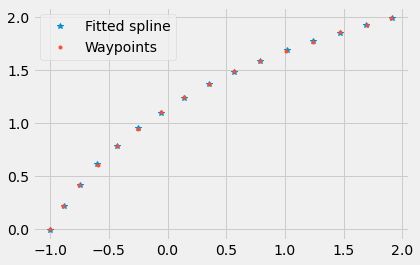

In [15]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

# Plan very far ahead, using the imported version of the function

/home/tianpeng/catkin_ws/src/fim_track/src/dLdp.py:52: RuntimeWarning: invalid value encountered in sqrt
  sum_eta += (ks[j]*bs[j])**2 * (r[j]-C1s[j])**(2*bs[j]-2) * rkrj * np.sqrt(1-rkrj**2) * direction
/home/tianpeng/catkin_ws/src/fim_track/src/FIMPathPlanning.py:53: RuntimeWarning: invalid value encountered in greater_equal
  if not np.all(np.linalg.norm(candid_ps-q,axis=1)>=epsilon):
/home/tianpeng/catkin_ws/src/fim_track/src/FIMPathPlanning.py:54: RuntimeWarning: invalid value encountered in less
  insiders=np.linalg.norm(candid_ps-q,axis=1)<epsilon


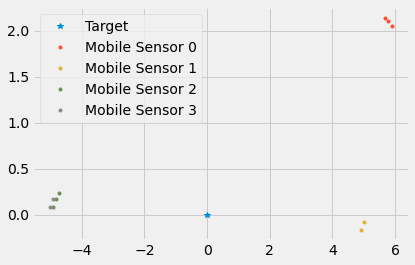

In [49]:
from FIMPathPlanning import FIM_ascent_path_planning
from dLdp import analytic_dLdp
from functools import partial
max_linear_speed=1.22
dt=0.1
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.,0])
C1s=np.array([0.1,0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.,1.1])
bs=np.array([-2,-2,-2,-2])

q=np.array([-0,-0])
ps=np.array([[6.,2],[5.1,0],[-5,0.0],[-5.1,-0.0]])

n_p=len(ps)
n_timesteps=100

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,n_p)

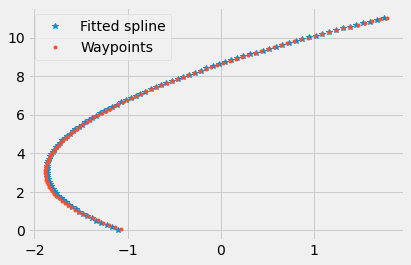

In [19]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

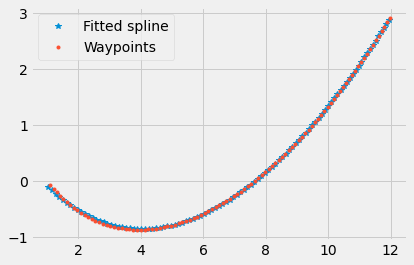

In [21]:
waypoints = p_trajs[:,0,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

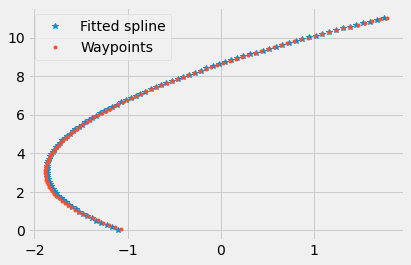

In [23]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

# With n_timestep <=100, the path planing is very fast.